# importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # for enhanced visualizations

# setting up the files path
- to be able to import the modules in the script folder

In [2]:
import sys
from pathlib import Path

scripts_path = Path('../scripts')
sys.path.append(str(scripts_path))

In [3]:
import sys
from pathlib import Path

# Assuming 'ingestion.py' is in the 'scripts' folder one level up
scripts_path = Path('./scripts')  # Changed to './scripts'
sys.path.append(str(scripts_path))

# Now, the import statement should work correctly
from ingestion import PostgreSQLConnection

## importing the module

In [4]:
from ingestion import PostgreSQLConnection

## setting up the connection

In [5]:
db_config = {
        'dbname': 'digital_store_DWH',
        'user': 'postgres',
        'password': '123', # User postgres password
        'host': 'localhost',
        'port': 5432
    }
db_connection = PostgreSQLConnection(**db_config)
db_connection.connect()

Connected to the digital_store_DWH database!


#  getting **Revenue by month**

In [6]:
# use db_connection.execute_extract_query(---#add your query here-----)
# then transform it into a Pandas DataFrame!
MonthlyRevenue= db_connection.execute_extract_query(
"""SELECT DATE_TRUNC('month', invoice_date) AS Month, SUM(total) AS MonthlyRevenue
FROM dw_schema.invoice_details
GROUP BY Month
ORDER BY Month;""")
MonthlyRevenue=pd.DataFrame(MonthlyRevenue,columns=['month','MonthlyRevenue'])
MonthlyRevenue.head()

,month,MonthlyRevenue
0,2021-01-01,35.64
1,2021-02-01,37.62
2,2021-03-01,37.62
3,2021-04-01,37.62
4,2021-05-01,37.62


## transforming the data for plotting

In [7]:
MonthlyRevenue = MonthlyRevenue.set_index('month')
MonthlyRevenue.index = MonthlyRevenue.index.strftime('%Y-%m')
MonthlyRevenue['MonthlyRevenue'] = pd.to_numeric(MonthlyRevenue['MonthlyRevenue'], errors='coerce')
MonthlyRevenue.head()


,MonthlyRevenue
month,
2021-01,35.64
2021-02,37.62
2021-03,37.62
2021-04,37.62
2021-05,37.62


In [8]:
print(MonthlyRevenue.dtypes)

MonthlyRevenue    float64
dtype: object


## Monthly Revenue plot

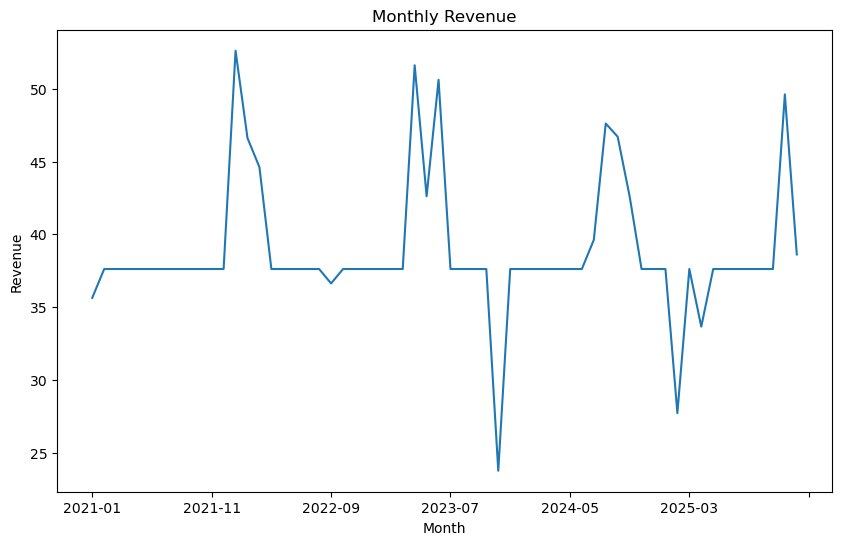

In [9]:
MonthlyRevenue['MonthlyRevenue'].plot(figsize=(10, 6), title='Monthly Revenue', legend=False)

plt.xlabel('Month')
plt.ylabel('Revenue')
plt.title('Monthly Revenue')

plt.show()

# Business Questions and Answers

## Question 1: If we want to hire a new employee, from which city should he be?

##Code - Query for Customer Count by City

In [10]:
city_customer_count= db_connection.execute_extract_query(
    """
    SELECT billing_city, COUNT(DISTINCT customer_id) AS customer_count
    FROM dw_schema.invoice_details
    GROUP BY billing_city
    ORDER BY customer_count DESC
    LIMIT 10; -- Showing top 10 cities
    """
)
city_customer_count_df=pd.DataFrame(city_customer_count,columns=['billing_city','customer_count'])
city_customer_count_df.head(10)

,billing_city,customer_count
0,Prague,2
1,London,2
2,Paris,2
3,São Paulo,2
4,Berlin,2
5,Mountain View,2
6,Brussels,1
7,Brasília,1
8,Chicago,1
9,Boston,1


 ## Code - Bar Chart Visualization

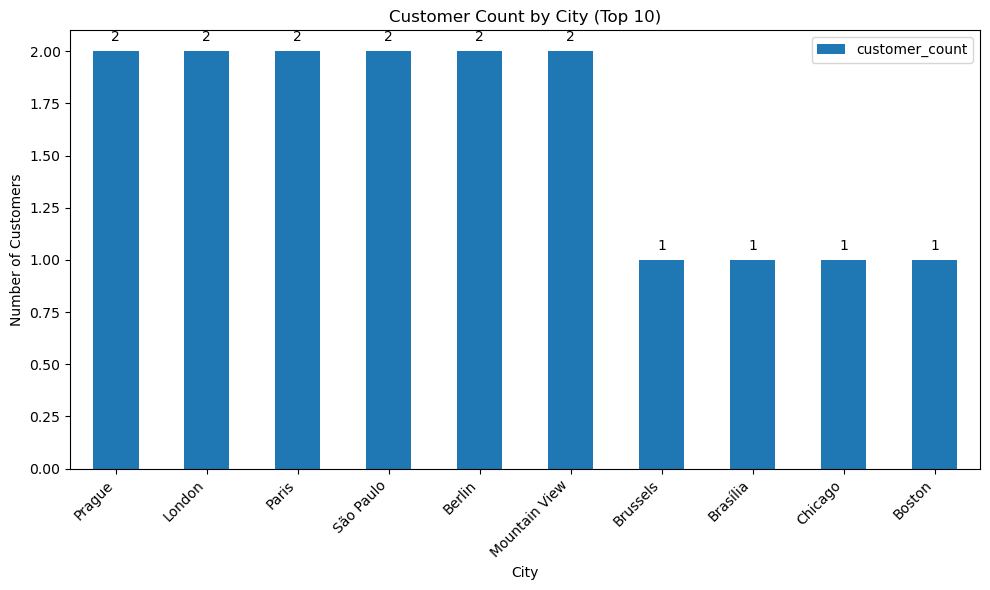

In [11]:
city_customer_count_df = city_customer_count_df.set_index('billing_city')
ax = city_customer_count_df.plot(kind='bar', figsize=(10, 6)) # Store axes object

plt.title('Customer Count by City (Top 10)')
plt.xlabel('City')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add annotations to bars
for p in ax.patches: # ax.patches gets the bar objects
    height = p.get_height()
    ax.annotate(f'{height:.0f}',  # Format count as integer
                (p.get_x() + p.get_width() / 2., height), # X and Y coordinates for annotation
                ha='center', va='bottom',
                xytext=(0, 5), textcoords='offset points') # Adjust position of text

plt.show()

## Question 2: In which period do sales increase?
## SQL Query for Monthly Revenue



In [12]:
# use db_connection.execute_extract_query(---#add your query here-----)
# then transform it into a Pandas DataFrame!
MonthlyRevenue= db_connection.execute_extract_query(
"""SELECT DATE_TRUNC('month', invoice_date) AS Month, SUM(total) AS MonthlyRevenue
FROM dw_schema.invoice_details
GROUP BY Month
ORDER BY Month;""")
MonthlyRevenue=pd.DataFrame(MonthlyRevenue,columns=['month','MonthlyRevenue'])
MonthlyRevenue.head()

,month,MonthlyRevenue
0,2021-01-01,35.64
1,2021-02-01,37.62
2,2021-03-01,37.62
3,2021-04-01,37.62
4,2021-05-01,37.62


## Transforming Data for Plotting

In [13]:
## transforming the data for plotting
MonthlyRevenue = MonthlyRevenue.set_index('month')
MonthlyRevenue.index = MonthlyRevenue.index.strftime('%Y-%m')
MonthlyRevenue['MonthlyRevenue'] = pd.to_numeric(MonthlyRevenue['MonthlyRevenue'], errors='coerce')
MonthlyRevenue.head()

,MonthlyRevenue
month,
2021-01,35.64
2021-02,37.62
2021-03,37.62
2021-04,37.62
2021-05,37.62


## Print Data Types

In [14]:
print(MonthlyRevenue.dtypes)

MonthlyRevenue    float64
dtype: object


## Creating the Monthly Revenue Plot



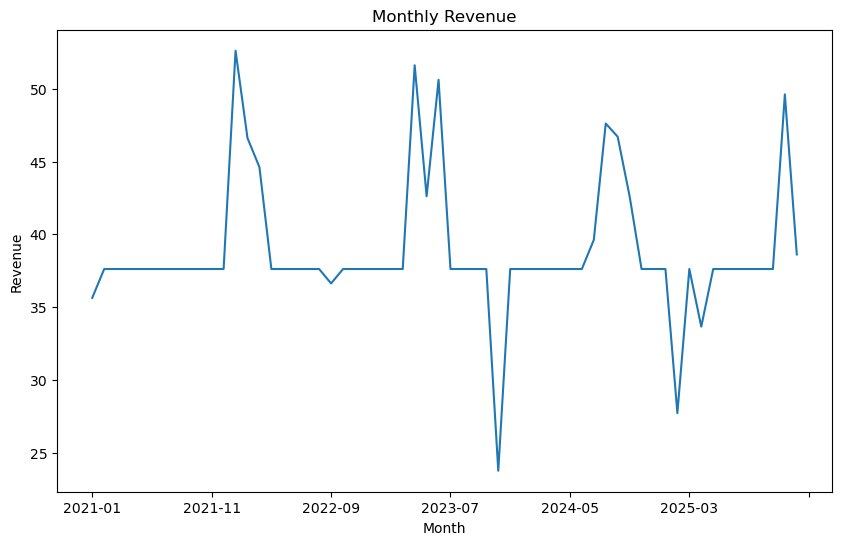

In [15]:
MonthlyRevenue['MonthlyRevenue'].plot(figsize=(10, 6), title='Monthly Revenue', legend=False)

plt.xlabel('Month')
plt.ylabel('Revenue')
plt.title('Monthly Revenue')

plt.show()

## Question 3: What is the average number of albums a customer buys?


##  SQL Query for Albums Purchased per Customer

In [16]:
# SQL Query to find the number of distinct albums purchased by each customer
album_purchases_per_customer = db_connection.execute_extract_query(
    """
    SELECT
        c.customer_id,
        c.first_name || ' ' || c.last_name AS customer_name,
        COUNT(DISTINCT t.album_id) AS distinct_albums_purchased
    FROM dw_schema.customer c
    JOIN dw_schema.invoice_details i ON c.customer_id = i.customer_id
    JOIN dw_schema.track t ON i.track_id = t.track_id
    GROUP BY c.customer_id, customer_name
    ORDER BY distinct_albums_purchased DESC;
    """
)
album_purchases_per_customer_df = pd.DataFrame(album_purchases_per_customer, columns=['customer_id', 'customer_name', 'distinct_albums_purchased'])
album_purchases_per_customer_df.head()

,customer_id,customer_name,distinct_albums_purchased
0,38,Niklas Schröder,27
1,3,François Tremblay,26
2,18,Michelle Brooks,26
3,36,Hannah Schneider,25
4,4,Bjørn Hansen,25


## Calculating Average Album Purchases



In [17]:
# Calculate the average number of albums purchased
average_albums_purchased = album_purchases_per_customer_df['distinct_albums_purchased'].mean()
print(f"Average number of distinct albums purchased per customer: {average_albums_purchased:.2f}")

Average number of distinct albums purchased per customer: 22.05


## Question 4: Is there a difference in the preferred track genre between regions?

##  Code - SQL Query for Track Genres by Country

In [18]:
# SQL Query to find preferred track genre by customer country
genre_preference_by_country = db_connection.execute_extract_query(
    """
    SELECT
        c.country AS customer_country,
        t.genre_name AS genre_name,
        COUNT(i.track_id) AS tracks_sold
    FROM dw_schema.customer c
    JOIN dw_schema.invoice_details i ON c.customer_id = i.customer_id
    JOIN dw_schema.track t ON i.track_id = t.track_id
    GROUP BY customer_country, genre_name
    ORDER BY tracks_sold DESC;
    """
)
genre_preference_by_country_df = pd.DataFrame(genre_preference_by_country, columns=['customer_country', 'genre_name', 'tracks_sold'])
genre_preference_by_country_df.head()

,customer_country,genre_name,tracks_sold
0,USA,Rock,157
1,Canada,Rock,107
2,USA,Latin,91
3,Brazil,Rock,81
4,France,Rock,65


In [19]:
# Create a pivot table for better visualization
genre_pivot_table = genre_preference_by_country_df.pivot_table(
    index='customer_country',
    columns='genre_name',
    fill_value=0
)

genre_pivot_table.head()

tracks_sold                                                \
genre_name       Alternative Alternative & Punk Blues Bossa Nova Classical   
customer_country                                                             
Argentina                  0                  9     0          0         0   
Australia                  0                  0     1          0         0   
Austria                    0                  0     0          0         2   
Belgium                    0                 14     0          0         0   
Brazil                     0                  7     6          0         6   

                                                                            \
genre_name       Comedy Drama Easy Listening Electronica/Dance Heavy Metal   
customer_country                                                             
Argentina             0     0              2                 0           0   
Australia             0     0              0                 0           3   
Austria               0     1              0                 0           0   
Belgium               0     0              0                 0           0   
Brazil                0     0              0                 0           0   

                  ...                                                          \
genre_name        ... Pop R&B/Soul Reggae Rock Rock And Roll Sci Fi & Fantasy   
customer_country  ...                                                           
Argentina         ...   0        0      0    9             0                0   
Australia         ...   0        0      2   22             0                0   
Austria           ...   1        4      0   15             0                0   
Belgium           ...   0        2      0   21             0                0   
Brazil            ...   3        3      6   81             0                2   

                                                            
genre_name       Science Fiction Soundtrack TV Shows World  
customer_country                                            
Argentina                      0          1        0     0  
Australia                      0          0        0     0  
Austria                        0          0        4     0  
Belgium                        0          0        0     0  
Brazil                         0          4        0     2  

[5 rows x 24 columns]

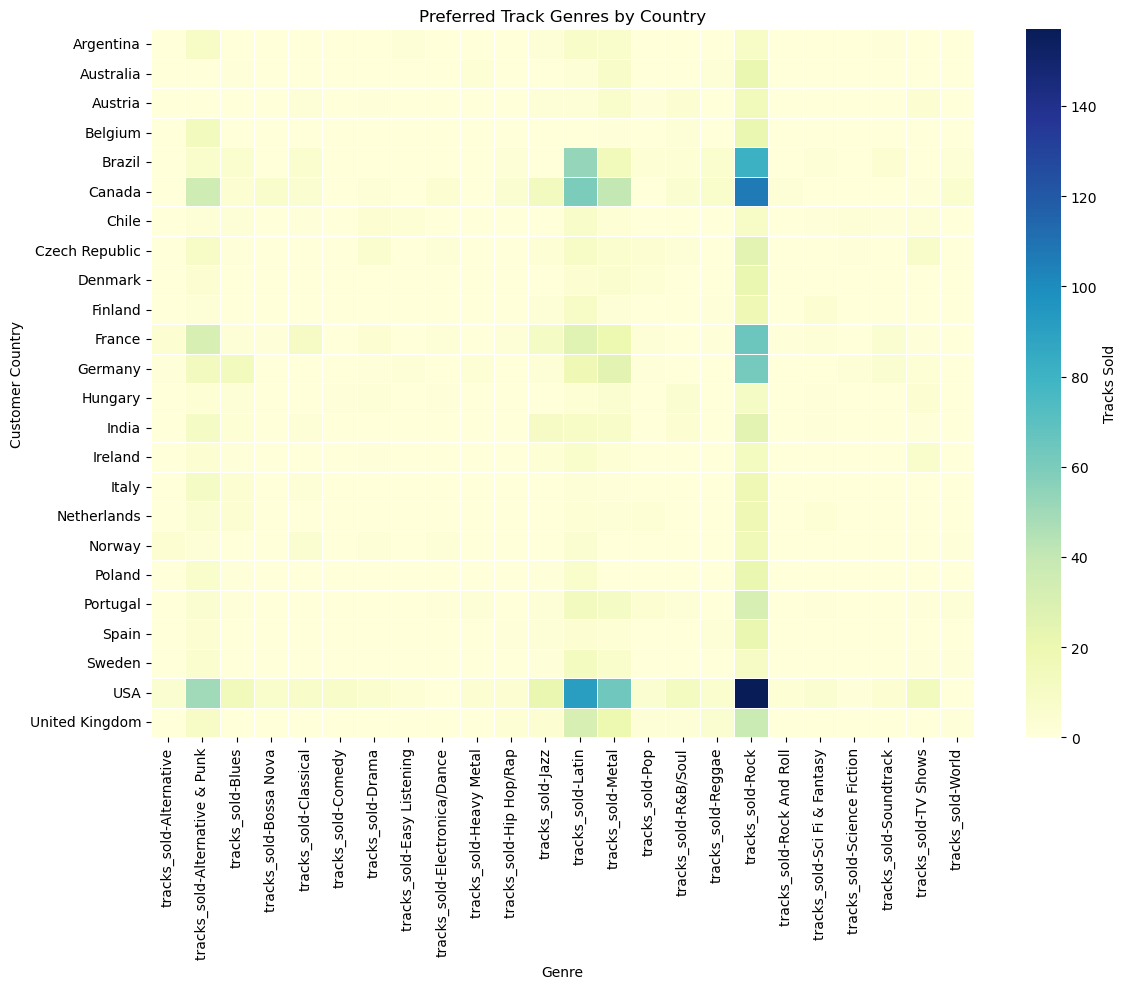

In [20]:
# Plotting heatmap to visualize genre preference by country
plt.figure(figsize=(12, 10))
sns.heatmap(genre_pivot_table, annot=False, cmap="YlGnBu", linewidths=.5, cbar_kws={'label': 'Tracks Sold'})
plt.title('Preferred Track Genres by Country')
plt.ylabel('Customer Country')
plt.xlabel('Genre')
plt.yticks(rotation=0) # Keep country names horizontal
plt.tight_layout()
plt.show()

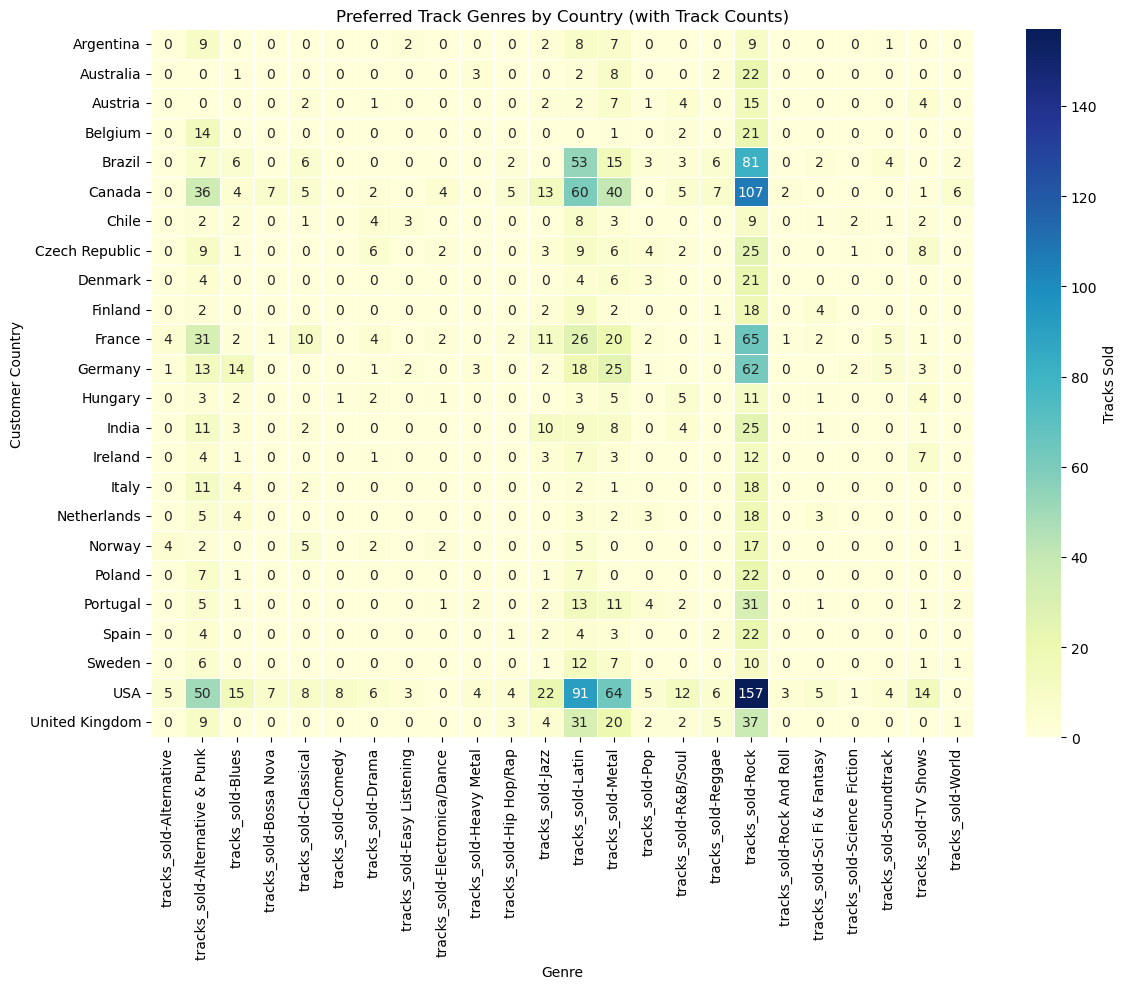

In [21]:
# Plotting heatmap to visualize genre preference by country (ANNOTATED)
plt.figure(figsize=(12, 10))
sns.heatmap(genre_pivot_table, annot=True, fmt="d", cmap="YlGnBu", linewidths=.5, cbar_kws={'label': 'Tracks Sold'}) # annot=True, fmt="d"
plt.title('Preferred Track Genres by Country (with Track Counts)') # Updated title
plt.ylabel('Customer Country')
plt.xlabel('Genre')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Question 5: Do older employees bring in more customers than newer employees?

In [22]:
# SQL Query to check if older employees bring in more customers
employee_customer_tenure = db_connection.execute_extract_query(
    """
    SELECT
        e.employee_id,
        e.first_name || ' ' || e.last_name AS employee_name,
        DATE_PART('year', e.hire_date) AS hire_year,
        COUNT(c.customer_id) AS customers_supported
    FROM dw_schema.employee e
    LEFT JOIN dw_schema.customer c ON e.employee_id = c.support_rep_id
    GROUP BY e.employee_id, employee_name, hire_year
    ORDER BY hire_year;
    """
)
employee_customer_tenure_df = pd.DataFrame(employee_customer_tenure, columns=['employee_id', 'employee_name', 'hire_year', 'customers_supported'])
employee_customer_tenure_df.head()

,employee_id,employee_name,hire_year,customers_supported
0,1,Andrew Adams,2002.0,0
1,3,Jane Peacock,2002.0,21
2,2,Nancy Edwards,2002.0,0
3,4,Margaret Park,2003.0,20
4,6,Michael Mitchell,2003.0,0


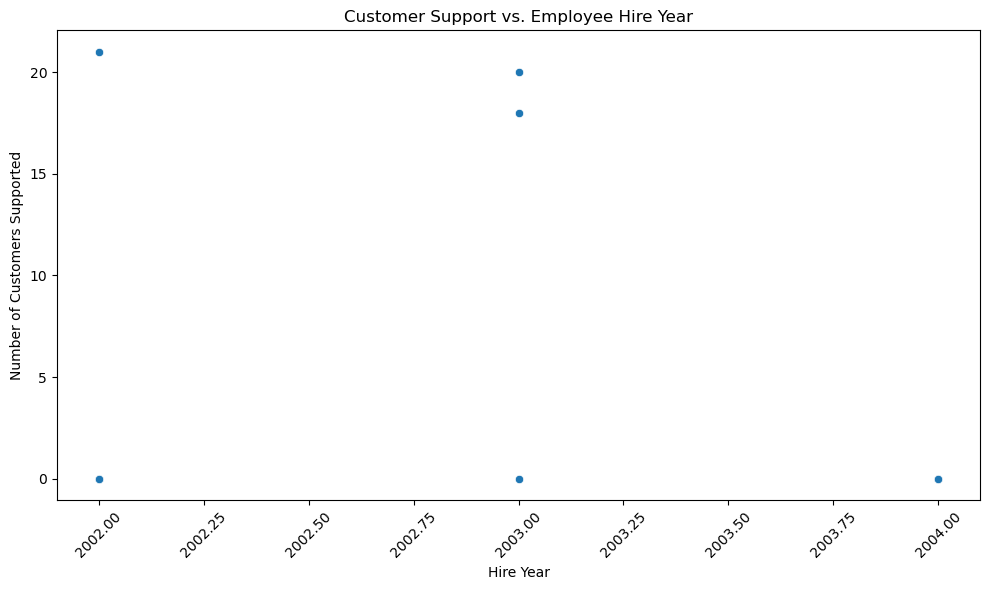

In [23]:
# Create a scatter plot to visualize the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(data=employee_customer_tenure_df, x='hire_year', y='customers_supported')
plt.title('Customer Support vs. Employee Hire Year')
plt.xlabel('Hire Year')
plt.ylabel('Number of Customers Supported')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Question 6: How much are the sales of the most famous artist?

In [24]:
# SQL Query to find sales of the most famous artist
artist_sales = db_connection.execute_extract_query(
    """
    SELECT
        ar.artist_name,
        SUM(i.unit_price * i.quantity) AS total_sales
    FROM dw_schema.album_details ar
    JOIN dw_schema.track t ON ar.album_id = t.album_id
    JOIN dw_schema.invoice_details i ON t.track_id = i.track_id
    GROUP BY ar.artist_name
    ORDER BY total_sales DESC
    LIMIT 1; -- To get only the most famous (top-selling) artist
    """
)
artist_sales_df = pd.DataFrame(artist_sales, columns=['artist_name', 'total_sales'])
artist_sales_df.head()

,artist_name,total_sales
0,Iron Maiden,138.60


 ## Displaying Most Famous Artist and Sales

In [25]:
# Display the most famous artist and their total sales
most_famous_artist = artist_sales_df['artist_name'].iloc[0] #iloc[0] to get the first artist name
most_famous_artist_sales = artist_sales_df['total_sales'].iloc[0] #iloc[0] to get the first artist sales

print(f"The most famous artist is: {most_famous_artist}")
print(f"Their total sales are: ${most_famous_artist_sales:.2f}") # Formatted to 2 decimal places for currency

The most famous artist is: Iron Maiden
Their total sales are: $138.60


## Question 7: What are the top-selling music genres?
## SQL Query for Genre Sales and DataFrame Creation



In [26]:
# use db_connection.execute_extract_query(---#add your query here-----)
# then transform it into a Pandas DataFrame!
genre_sales = db_connection.execute_extract_query(
    """
    SELECT
        t.genre_name,
        SUM(t.unit_price * i.quantity) AS total_sales
    FROM dw_schema.track t
    JOIN dw_schema.invoice_details i ON t.track_id = i.track_id
    GROUP BY t.genre_name
    ORDER BY total_sales DESC
    LIMIT 10; -- Top 10 genres by sales
    """
)
genre_sales_df = pd.DataFrame(genre_sales, columns=['genre_name', 'total_sales'])
genre_sales_df['total_sales'] = genre_sales_df['total_sales'].astype(float)
genre_sales_df.head(10)

,genre_name,total_sales
0,Rock,826.65
1,Latin,382.14
2,Metal,261.36
3,Alternative & Punk,241.56
4,TV Shows,93.53
5,Jazz,79.20
6,Blues,60.39
7,Drama,57.71
8,R&B/Soul,40.59
9,Classical,40.59


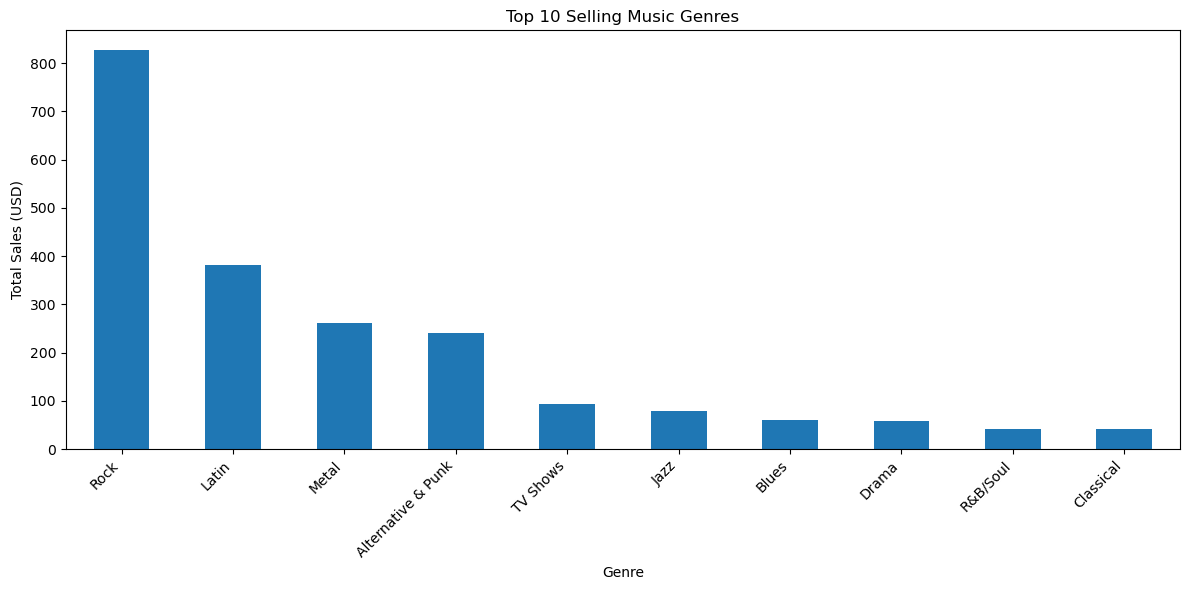

In [27]:
genre_sales_df = genre_sales_df.set_index('genre_name')

genre_sales_df['total_sales'].plot(kind='bar', figsize=(12, 6))
plt.ylabel('Total Sales (USD)')
plt.xlabel('Genre')
plt.title('Top 10 Selling Music Genres')
plt.xticks(rotation=45, ha='right')
plt.legend().set_visible(False) # Disable legend for single bar series
plt.tight_layout()
plt.show()

## Question 8: What are the best-selling media types?
## SQL Query for Media Type Sales and DataFrame Creation

In [28]:
# SQL Query to find best-selling media types (Snowflake Schema)
media_type_sales = db_connection.execute_extract_query(
    """
    SELECT
        t.media_type_name,
        SUM(i.unit_price * i.quantity) AS total_sales
    FROM dw_schema.track t
    JOIN dw_schema.invoice_details i ON t.track_id = i.track_id
    GROUP BY t.media_type_name
    ORDER BY total_sales DESC
    LIMIT 10; -- Top 10 media types by sales
    """
)
media_type_sales_df = pd.DataFrame(media_type_sales, columns=['media_type_name', 'total_sales'])
media_type_sales_df['total_sales'] = media_type_sales_df['total_sales'].astype(float)
media_type_sales_df.head(10)

,media_type_name,total_sales
0,MPEG audio file,1956.24
1,Protected MPEG-4 video file,220.89
2,Protected AAC audio file,144.54
3,Purchased AAC audio file,3.96
4,AAC audio file,2.97


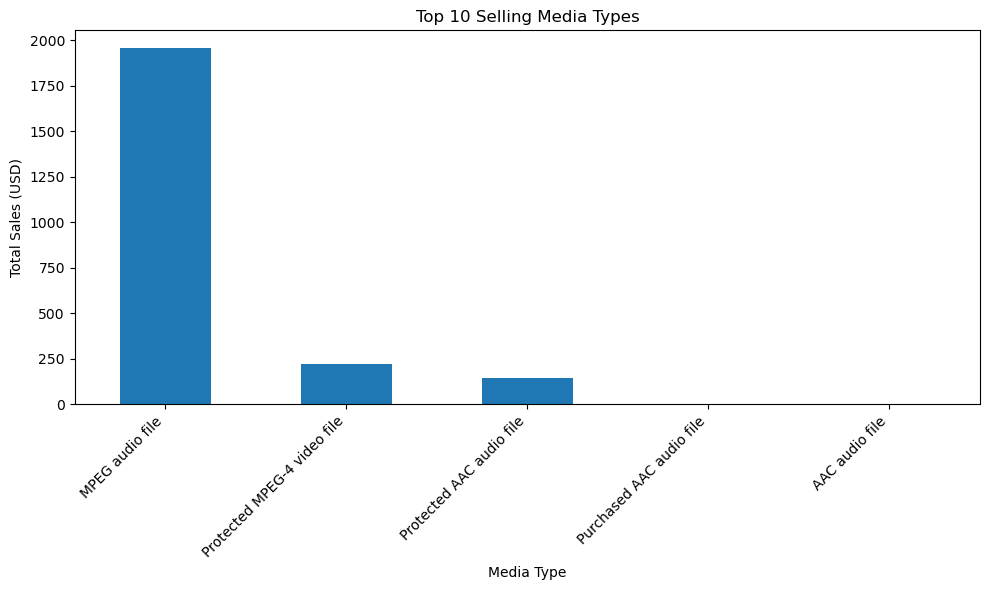

In [29]:
media_type_sales_df = media_type_sales_df.set_index('media_type_name')

media_type_sales_df['total_sales'].plot(kind='bar', figsize=(10, 6))
plt.ylabel('Total Sales (USD)')
plt.xlabel('Media Type')
plt.title('Top 10 Selling Media Types')
plt.xticks(rotation=45, ha='right')
plt.legend().set_visible(False) # Disable legend
plt.tight_layout()
plt.show()

## Question 9: Which employees are the top sales performers?
## SQL Query for Employee Sales and DataFrame Creation

In [30]:
# SQL Query to find top sales employees (Snowflake Schema)
top_employee_sales = db_connection.execute_extract_query(
    """
    SELECT
        e.employee_id,
        e.first_name || ' ' || e.last_name AS employee_name,
        SUM(i.total) AS total_sales
    FROM dw_schema.employee e  -- Table name is dw_schema.employee_details
    LEFT JOIN dw_schema.customer c ON e.employee_id = c.support_rep_id
    LEFT JOIN dw_schema.invoice_details i ON c.customer_id = i.customer_id
    WHERE e.title LIKE '%Sales Support Agent%' -- Filter for Sales Support Agents
    GROUP BY e.employee_id, employee_name
    ORDER BY total_sales DESC
    LIMIT 5; -- Top 5 sales employees
    """
)
top_employee_sales_df = pd.DataFrame(top_employee_sales, columns=['employee_id', 'employee_name', 'total_sales'])
top_employee_sales_df['total_sales'] = top_employee_sales_df['total_sales'].astype(float)
top_employee_sales_df.head()

,employee_id,employee_name,total_sales
0,3,Jane Peacock,833.04
1,4,Margaret Park,775.40
2,5,Steve Johnson,720.16


## Bar Chart Visualization for Top Employee Sales

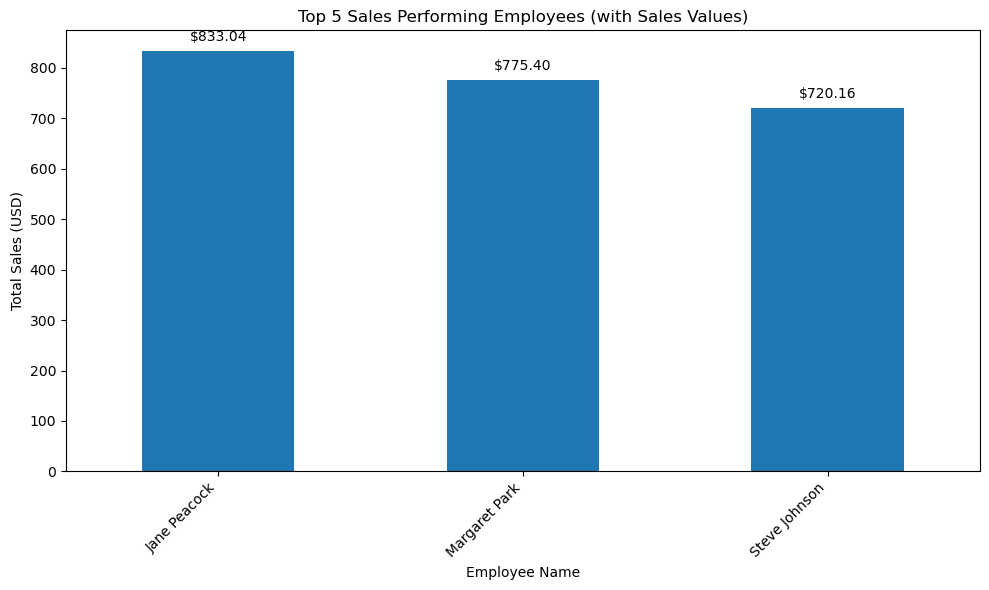

In [31]:
top_employee_sales_df = top_employee_sales_df.set_index('employee_name')

ax = top_employee_sales_df['total_sales'].plot(kind='bar', figsize=(10, 6)) # Store axes object
plt.ylabel('Total Sales (USD)')
plt.xlabel('Employee Name')
plt.title('Top 5 Sales Performing Employees (with Sales Values)') # Updated title
plt.xticks(rotation=45, ha='right')
plt.legend().set_visible(False) # Disable legend
plt.tight_layout()

# Add annotations to bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'${height:.2f}', # Formatted as currency
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                xytext=(0, 5), textcoords='offset points')

plt.show()

## Question 10: What is the average purchase value of customers from different countries?

##  SQL Query for Average Purchase Value by Country and DataFrame Creation



In [32]:
# SQL Query to find average purchase value by customer country (Snowflake Schema)
avg_purchase_value_country = db_connection.execute_extract_query(
    """
    SELECT
        c.country AS customer_country,
        AVG(i.total) AS average_order_value
    FROM dw_schema.customer c
    JOIN dw_schema.invoice_details i ON c.customer_id = i.customer_id
    GROUP BY customer_country
    ORDER BY average_order_value DESC;
    """
)
avg_purchase_value_country_df = pd.DataFrame(avg_purchase_value_country, columns=['customer_country', 'average_order_value'])
avg_purchase_value_country_df['average_order_value'] = avg_purchase_value_country_df['average_order_value'].astype(float)
avg_purchase_value_country_df.head()

,customer_country,average_order_value
0,Chile,1.226842
1,Hungary,1.200526
2,Ireland,1.200526
3,Czech Republic,1.187368
4,Austria,1.121579


## Bar Chart Visualization for Top Selling Music Genres

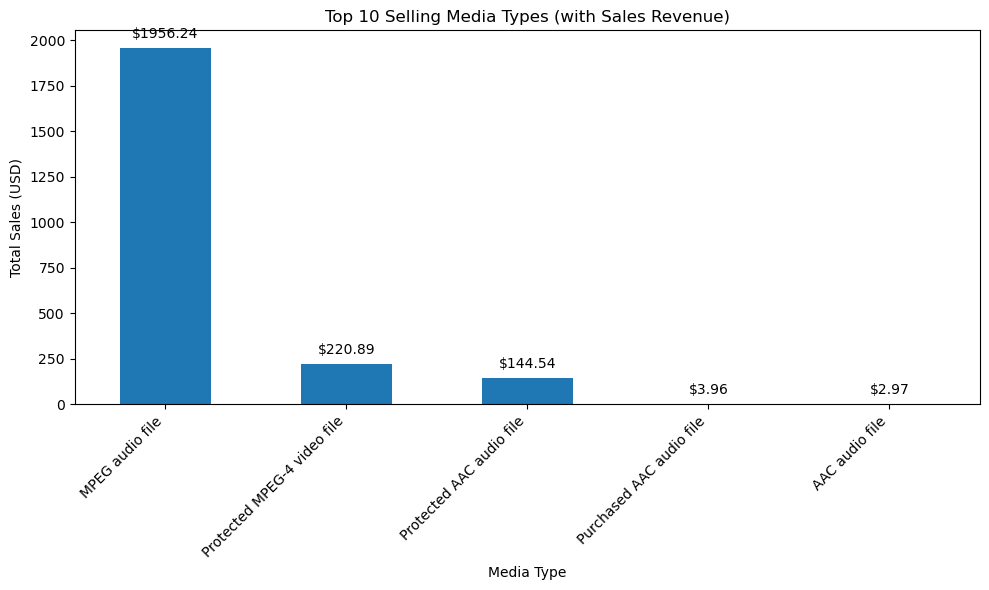

In [33]:
ax = media_type_sales_df['total_sales'].plot(kind='bar', figsize=(10, 6)) # Store axes object
plt.ylabel('Total Sales (USD)')
plt.xlabel('Media Type')
plt.title('Top 10 Selling Media Types (with Sales Revenue)') # Updated title
plt.xticks(rotation=45, ha='right')
plt.legend().set_visible(False) # Disable legend
plt.tight_layout()

# Add annotations to bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'${height:.2f}', # Formatted as currency
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                xytext=(0, 5), textcoords='offset points')

plt.show()

## Bar Chart Visualization for Average Purchase Value by Country

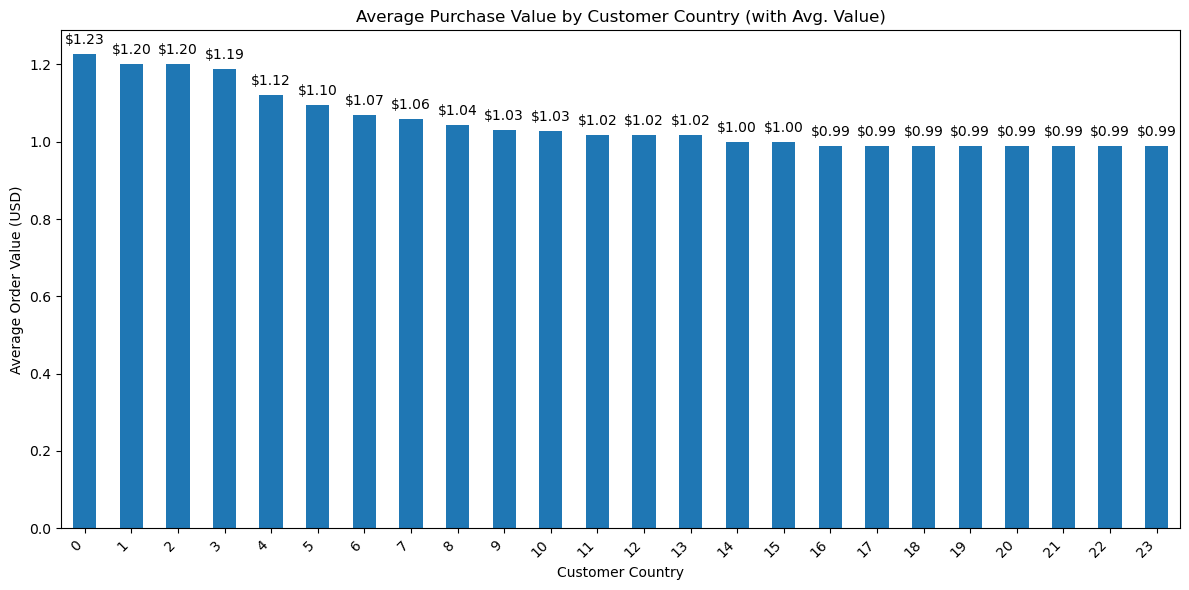

In [34]:
ax = avg_purchase_value_country_df['average_order_value'].plot(kind='bar', figsize=(12, 6)) # Store axes object
plt.ylabel('Average Order Value (USD)')
plt.xlabel('Customer Country')
plt.title('Average Purchase Value by Customer Country (with Avg. Value)') # Updated title
plt.xticks(rotation=45, ha='right')
plt.legend().set_visible(False) # Disable legend
plt.tight_layout()

# Add annotations to bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'${height:.2f}',  # Formatted as currency
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                xytext=(0, 5), textcoords='offset points')

plt.show()

## Question 11: Repeat Purchasers
## Question 11: How many customers are repeat purchasers?

In [35]:
# SQL Query to count repeat customers (Snowflake Schema)
repeat_customer_count = db_connection.execute_extract_query(
    """
    SELECT COUNT(*) AS repeat_customer_count
    FROM (
        SELECT customer_id
        FROM dw_schema.invoice_details
        GROUP BY customer_id
        HAVING COUNT(*) > 1 -- Customers with more than one invoice
    ) AS repeat_customers;
    """
)
repeat_customer_count_df = pd.DataFrame(repeat_customer_count, columns=['repeat_customer_count'])
repeat_customer_count_df.head()

,repeat_customer_count
0,59


## Displaying Repeat Customer Count


In [36]:
# Display the count of repeat customers
num_repeat_customers = repeat_customer_count_df['repeat_customer_count'].iloc[0]

print(f"Number of repeat customers: {num_repeat_customers}")

Number of repeat customers: 59


## Question 12: What is the average price for each track genre?



            genre_name  average_track_price
0     Sci Fi & Fantasy                 1.99
1               Comedy                 1.99
2             TV Shows                 1.99
3                Drama                 1.99
4      Science Fiction                 1.99
5             R&B/Soul                 0.99
6          Alternative                 0.99
7           Bossa Nova                 0.99
8                Latin                 0.99
9          Hip Hop/Rap                 0.99
10       Rock And Roll                 0.99
11               Opera                 0.99
12           Classical                 0.99
13                 Pop                 0.99
14  Alternative & Punk                 0.99
15                Rock                 0.99
16               Metal                 0.99
17                Jazz                 0.99
18               World                 0.99
19          Soundtrack                 0.99
20         Heavy Metal                 0.99
21   Electronica/Dance          

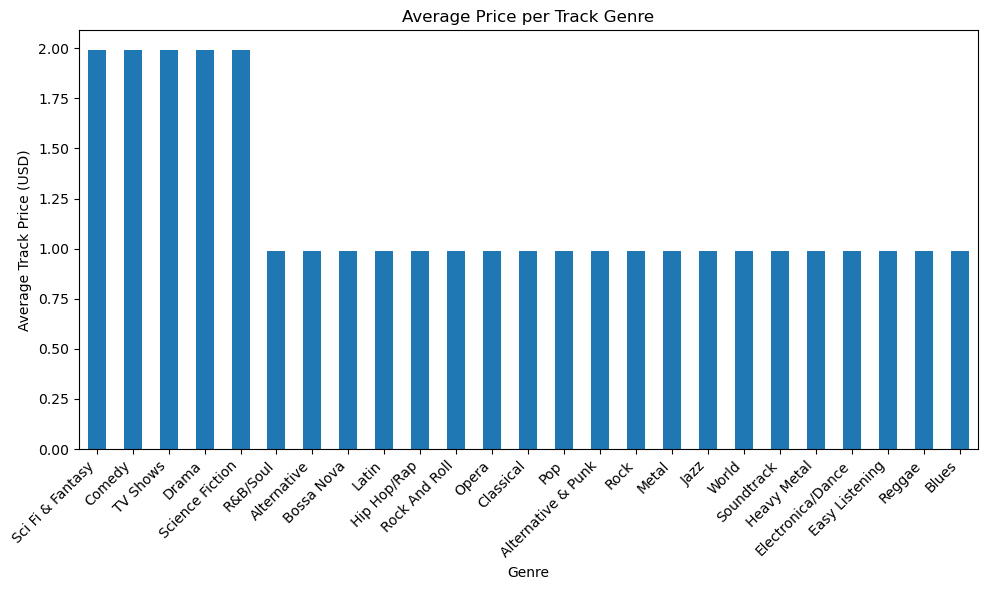

In [37]:
genre_avg_price = db_connection.execute_extract_query(
    """
    SELECT
        t.genre_name,
        AVG(t.unit_price) AS average_track_price
    FROM dw_schema.track t
    GROUP BY t.genre_name
    ORDER BY average_track_price DESC; -- Highest priced genres first
    """
)
genre_avg_price_df = pd.DataFrame(genre_avg_price, columns=['genre_name', 'average_track_price'])
genre_avg_price_df['average_track_price'] = genre_avg_price_df['average_track_price'].astype(float)
print(genre_avg_price_df)

genre_avg_price_df = genre_avg_price_df.set_index('genre_name')

genre_avg_price_df['average_track_price'].plot(kind='bar', figsize=(10, 6))
plt.ylabel('Average Track Price (USD)')
plt.xlabel('Genre')
plt.title('Average Price per Track Genre')
plt.xticks(rotation=45, ha='right')
plt.legend().set_visible(False)
plt.tight_layout()
plt.show()

## Question 13: What are the top 5 best-selling tracks overall?

                      name  total_sold
0              The Trooper         5.0
1     Hallowed Be Thy Name         4.0
2                 Eruption         4.0
3      Sure Know Something         4.0
4  The Number Of The Beast         4.0


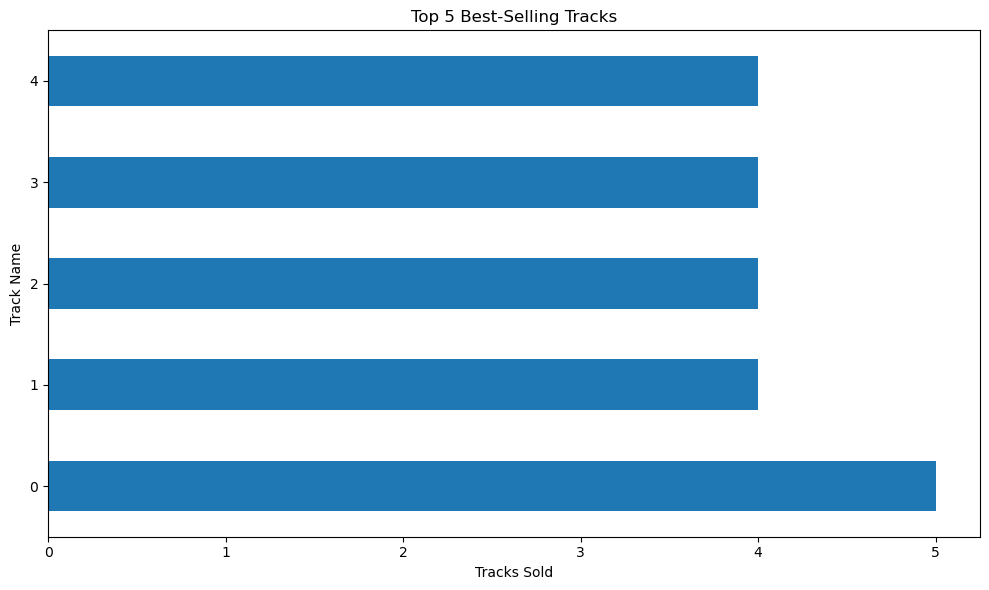

In [38]:
top_selling_tracks = db_connection.execute_extract_query(
    """
    SELECT
        t.name,
        COUNT(i.track_id) AS total_sold
    FROM dw_schema.track t
    JOIN dw_schema.invoice_details i ON t.track_id = i.track_id
    GROUP BY t.name
    ORDER BY total_sold DESC
    LIMIT 5; -- Top 5 best-selling tracks
    """
)
top_selling_tracks_df = pd.DataFrame(top_selling_tracks, columns=['name', 'total_sold'])
top_selling_tracks_df['total_sold'] = top_selling_tracks_df['total_sold'].astype(float)
print(top_selling_tracks_df)

# top_selling_tracks_df = top_selling_tracks_df.set_index('track_name')

top_selling_tracks_df['total_sold'].plot(kind='barh', figsize=(10, 6))
plt.xlabel('Tracks Sold')
plt.ylabel('Track Name')
plt.title('Top 5 Best-Selling Tracks')
plt.tight_layout()
plt.show()